# SegResNet

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NachoGV/semantic-Segmentation-of-Brain-Metastases-in-MRI-Scans/blob/main/models/SegResNet.ipynb)

## Environment Set Up

### Requirements

In [1]:
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

### Colab Integration

In [2]:
# Set up Colab Workspace
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

!ln -s /content/drive/MyDrive/TFM/data /content/data
!ln -s /content/drive/MyDrive/TFM/utils /content/utils
!ln -s /content/drive/MyDrive/TFM/outputs /content/outputs

Mounted at /content/drive


### Imports

In [3]:
# System
import os
import time
from math import nan

# Data Load & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Monai
from monai.data import DataLoader
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.data import decollate_batch
from monai.utils import set_determinism
from monai.networks.nets import SegResNet
from monai.handlers.utils import from_engine
from monai.inferers import sliding_window_inference

# PyTorch
import torch
from torch.utils.data import SequentialSampler

# Utils
from utils.Transforms import Transforms
from utils.plots import plot_gt_vs_pred
from utils.UCSF_Dataset import UCSF_Dataset

### Config

In [4]:
# Check if CUDA is available
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")

# Print the device
print(f"Device: {device}")

Running on GPU
Device: cuda


In [5]:
# Seeds
seed = 33
set_determinism(seed=seed) # Monai
np.random.seed(seed) # Numpy
torch.manual_seed(seed) # PyTorch

# Others
%matplotlib inline
pd.set_option("display.max_columns", None)
model_name = "SegResNet"

## Load Data

In [6]:
# Load Subjects Information
train_df = pd.read_csv('data/TRAIN.csv')
val_df = pd.read_csv('data/VAL.csv')
test_df = pd.read_csv('data/TEST.csv')

train_df.head()

,SubjectID,Sex,CancerType,ScannerType,In-plane voxel size (mm),Matrix size,Prior Craniotomy/Biopsy/Resection,Age,Scanner Strength (Tesla),Slice Thickness (mm),NumberMetastases,VolumeMetastases_mm3,S-NM,S-V,S-VMax,S-VMin,S-VMean,S-VStd,S-VDiff,T1pre,FLAIR,T1post,T2Synth,Seg,BraTS-seg
0,100381A,Male,Lung,GE 1.5 T Signa HDxt,0.86x0.86,256x256x126,No,71.0,1.5,1.5,4.0,3082.045582,4.0,3082.045541,2445.030377,77.549672,770.511385,974.806455,4.146686e-05,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...
1,100414B,Female,Breast,GE 1.5 T Signa HDxt,0.59x0.59,512x512x50,No,52.0,1.5,3.0,5.0,84.446590,5.0,84.446586,22.656401,11.328201,16.889317,3.940386,3.629621e-06,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...
2,100132B,Male,Lung,GE 1.5 T Signa HDxt,0.5x0.5,512x512x156,No,55.0,1.5,1.2,5.0,734.400029,5.0,734.400029,236.700009,81.300003,146.880006,64.989060,1.136868e-13,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...
3,100212A,Female,Lung,GE 1.5 T Signa HDxt,1.17x1.17,256x256x98,No,52.0,1.5,1.5,9.0,208.062478,9.0,208.062474,43.260514,16.480196,23.118053,7.876000,3.481233e-06,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...
4,100243B,Female,Breast,GE 1.5 T Signa HDxt,0.86x0.86,256x256x100,No,55.0,1.5,1.5,6.0,517.367105,6.0,517.367098,173.932836,8.862820,86.227850,52.711028,6.960829e-06,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...


In [7]:
b_size = 1
t_size = None
v_size = None
spatial_size = (240, 240, 160)

In [8]:
transforms = Transforms(seed)

# Train Dataset
train_images = [train_df['T1pre'], train_df['FLAIR'], train_df['T1post'], train_df['T2Synth']]
train_labels = train_df['BraTS-seg']
train_dataset = UCSF_Dataset(train_images, train_labels, transforms.train(spatial_size=spatial_size), t_size)

# Validation Dataset
val_images = [val_df['T1pre'], val_df['FLAIR'], val_df['T1post'], val_df['T2Synth']]
val_labels = val_df['BraTS-seg']
val_dataset = UCSF_Dataset(val_images, val_labels, transforms.val(), v_size)

# Samplers
train_sampler = SequentialSampler(train_dataset)
val_sampler = SequentialSampler(val_dataset)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=False, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, sampler=val_sampler)

## Training

### Parameters

In [9]:
# Training
max_epochs = 10
VAL_AMP = True
lr = 1e-4
weight_decay = 1e-5

# Report Frequency
plt_imgs = []
val_interval = 1
plot_interval = 1
best_metric_update = False
max_step = len(train_dataset) // train_loader.batch_size - 1
max_val_step = len(val_dataset) // val_loader.batch_size - 3

# Metrics Storages
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
val_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []
with open(f"outputs/{model_name}/{model_name}_metrics.csv", "a") as f:
  f.write(f"epoch,metric,metric_tc,metric_wt,metric_et,train_loss,val_loss\n")

### Model, Loss, Optimizer & Inference

In [10]:
# Model
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).to(device)

# Loss Function
loss_function = DiceLoss(smooth_nr=1e-5, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

# Metrics
dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

# Inference Method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=spatial_size,
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)

# AMP to accelerate training
scaler = torch.cuda.amp.GradScaler()

# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

### Training Process

----------
epoch 1/10
TRAIN
   Batch 1/248, train_loss: 0.9673, step time: 7.8483
   Batch 2/248, train_loss: 0.9999, step time: 1.2831
   Batch 3/248, train_loss: 0.9991, step time: 1.3061
   Batch 4/248, train_loss: 0.9999, step time: 1.2982
   Batch 5/248, train_loss: 0.9962, step time: 1.3241
   Batch 6/248, train_loss: 0.9953, step time: 1.2963
   Batch 7/248, train_loss: 0.9227, step time: 1.3188
   Batch 8/248, train_loss: 0.9852, step time: 1.3189
   Batch 9/248, train_loss: 0.9496, step time: 1.3289
   Batch 10/248, train_loss: 0.9981, step time: 1.2912
   Batch 11/248, train_loss: 0.9964, step time: 1.3078
   Batch 12/248, train_loss: 0.9998, step time: 1.3165
   Batch 13/248, train_loss: 0.9985, step time: 1.2970
   Batch 14/248, train_loss: 0.8822, step time: 1.3169
   Batch 15/248, train_loss: 0.9974, step time: 1.3412
   Batch 16/248, train_loss: 0.9939, step time: 1.3117
   Batch 17/248, train_loss: 0.9998, step time: 1.3204
   Batch 18/248, train_loss: 0.9994, step time

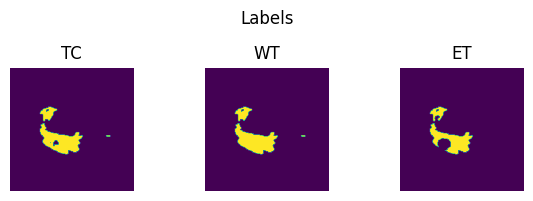

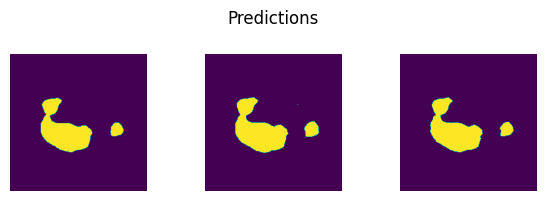

VAL
   Batch 1/31, val_loss: 0.9839
   Batch 2/31, val_loss: 1.0000
   Batch 3/31, val_loss: 0.9998
   Batch 4/31, val_loss: 0.9984
   Batch 5/31, val_loss: 1.0000
   Batch 6/31, val_loss: 0.9077
   Batch 7/31, val_loss: 0.9792
   Batch 8/31, val_loss: 0.9983
   Batch 9/31, val_loss: 0.9207
   Batch 10/31, val_loss: 0.9973
   Batch 11/31, val_loss: 0.9859
   Batch 12/31, val_loss: 0.9992
   Batch 13/31, val_loss: 0.9987
   Batch 14/31, val_loss: 0.9983
   Batch 15/31, val_loss: 1.0000
   Batch 16/31, val_loss: 0.9995
   Batch 17/31, val_loss: 0.9998
   Batch 18/31, val_loss: 0.9986
   Batch 19/31, val_loss: 0.9625
   Batch 20/31, val_loss: 0.9831
   Batch 21/31, val_loss: 0.9928
   Batch 22/31, val_loss: 0.9997
   Batch 23/31, val_loss: 0.9996
   Batch 24/31, val_loss: 0.8844
   Batch 25/31, val_loss: 0.9743
   Batch 26/31, val_loss: 0.9952
   Batch 27/31, val_loss: 0.9999
   Batch 28/31, val_loss: 0.9700
   Batch 29/31, val_loss: 0.9999
   Batch 30/31, val_loss: 0.9995
   Batch 31/31,

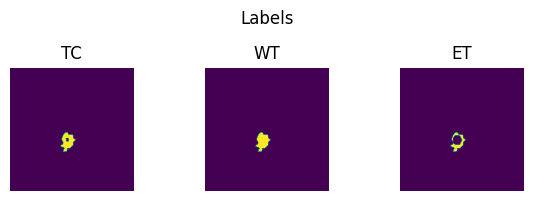

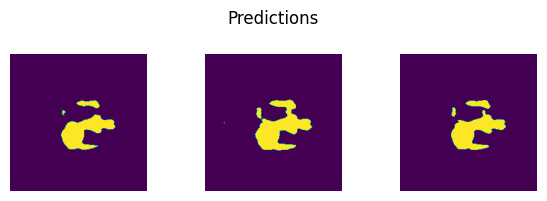

epoch 1
   average train loss: 0.9743
   average validation loss: 0.9847
   saved as best model: True
   current mean dice: 0.1255
   current TC dice: 0.1426
   current WT dice: 0.1209
   current ET dice: 0.1250
Best Mean Metric: 0.1255
time consuming of epoch 1 is: 4966.6315
----------
epoch 2/10
TRAIN
   Batch 1/248, train_loss: 0.9022, step time: 1.3768
   Batch 2/248, train_loss: 0.9999, step time: 1.2950
   Batch 3/248, train_loss: 0.9984, step time: 1.3153
   Batch 4/248, train_loss: 0.9999, step time: 1.2828
   Batch 5/248, train_loss: 0.9915, step time: 1.3081
   Batch 6/248, train_loss: 0.9909, step time: 1.3020
   Batch 7/248, train_loss: 0.8600, step time: 1.3200
   Batch 8/248, train_loss: 0.9755, step time: 1.3199
   Batch 9/248, train_loss: 0.9138, step time: 1.3199
   Batch 10/248, train_loss: 0.9967, step time: 1.2897
   Batch 11/248, train_loss: 0.9929, step time: 1.3160
   Batch 12/248, train_loss: 0.9998, step time: 1.2976
   Batch 13/248, train_loss: 0.9978, step ti

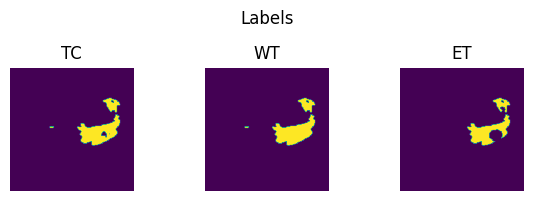

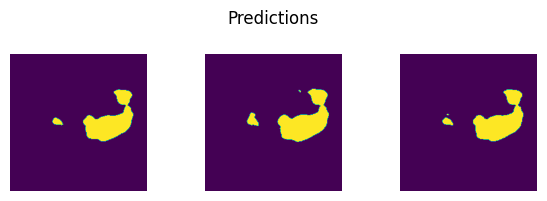

VAL
   Batch 1/31, val_loss: 0.9804
   Batch 2/31, val_loss: 1.0000
   Batch 3/31, val_loss: 0.9997
   Batch 4/31, val_loss: 0.9980
   Batch 5/31, val_loss: 1.0000
   Batch 6/31, val_loss: 0.8926
   Batch 7/31, val_loss: 0.9747
   Batch 8/31, val_loss: 0.9979
   Batch 9/31, val_loss: 0.9053
   Batch 10/31, val_loss: 0.9963
   Batch 11/31, val_loss: 0.9819
   Batch 12/31, val_loss: 0.9989
   Batch 13/31, val_loss: 0.9983
   Batch 14/31, val_loss: 0.9977
   Batch 15/31, val_loss: 0.9999
   Batch 16/31, val_loss: 0.9993
   Batch 17/31, val_loss: 0.9997
   Batch 18/31, val_loss: 0.9978
   Batch 19/31, val_loss: 0.9540
   Batch 20/31, val_loss: 0.9799
   Batch 21/31, val_loss: 0.9898
   Batch 22/31, val_loss: 0.9997
   Batch 23/31, val_loss: 0.9997
   Batch 24/31, val_loss: 0.8699
   Batch 25/31, val_loss: 0.9680
   Batch 26/31, val_loss: 0.9938
   Batch 27/31, val_loss: 0.9998
   Batch 28/31, val_loss: 0.9604
   Batch 29/31, val_loss: 0.9999
   Batch 30/31, val_loss: 0.9994
   Batch 31/31,

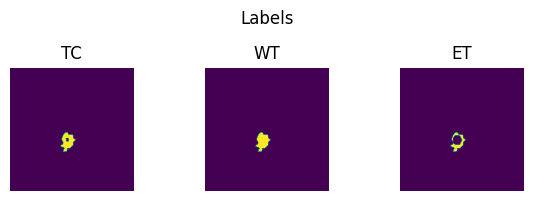

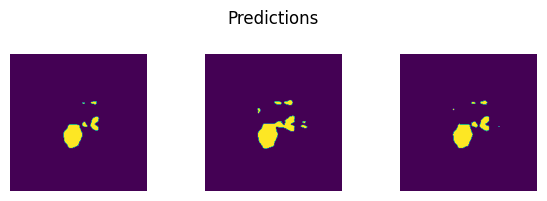

epoch 2
   average train loss: 0.9674
   average validation loss: 0.9817
   saved as best model: True
   current mean dice: 0.1813
   current TC dice: 0.2008
   current WT dice: 0.1795
   current ET dice: 0.1811
Best Mean Metric: 0.1813
time consuming of epoch 2 is: 1666.4421
----------
epoch 3/10
TRAIN
   Batch 1/248, train_loss: 0.8828, step time: 1.4183
   Batch 2/248, train_loss: 0.9998, step time: 1.3432
   Batch 3/248, train_loss: 0.9979, step time: 1.3408
   Batch 4/248, train_loss: 0.9999, step time: 1.3271
   Batch 5/248, train_loss: 0.9893, step time: 1.3461
   Batch 6/248, train_loss: 0.9888, step time: 1.3798
   Batch 7/248, train_loss: 0.8279, step time: 1.3812
   Batch 8/248, train_loss: 0.9704, step time: 1.3627
   Batch 9/248, train_loss: 0.8931, step time: 1.3979
   Batch 10/248, train_loss: 0.9956, step time: 1.3850
   Batch 11/248, train_loss: 0.9906, step time: 1.3903
   Batch 12/248, train_loss: 0.9998, step time: 1.3720
   Batch 13/248, train_loss: 0.9971, step ti

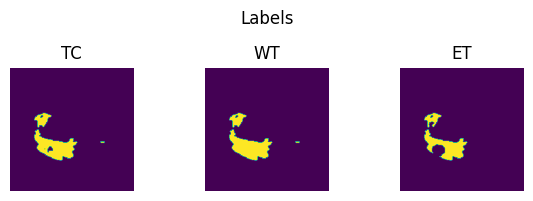

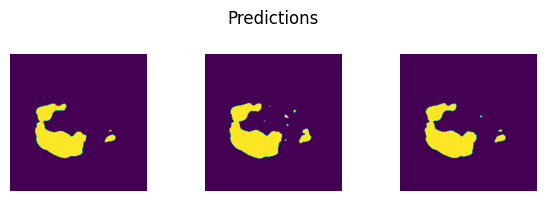

VAL
   Batch 1/31, val_loss: 0.9787
   Batch 2/31, val_loss: 0.9999
   Batch 3/31, val_loss: 0.9997
   Batch 4/31, val_loss: 0.9975
   Batch 5/31, val_loss: 1.0000
   Batch 6/31, val_loss: 0.8752
   Batch 7/31, val_loss: 0.9722
   Batch 8/31, val_loss: 0.9977
   Batch 9/31, val_loss: 0.8951
   Batch 10/31, val_loss: 0.9964
   Batch 11/31, val_loss: 0.9809
   Batch 12/31, val_loss: 0.9988
   Batch 13/31, val_loss: 0.9979
   Batch 14/31, val_loss: 0.9974
   Batch 15/31, val_loss: 0.9999
   Batch 16/31, val_loss: 0.9993
   Batch 17/31, val_loss: 0.9996
   Batch 18/31, val_loss: 0.9981
   Batch 19/31, val_loss: 0.9486
   Batch 20/31, val_loss: 0.9773
   Batch 21/31, val_loss: 0.9905
   Batch 22/31, val_loss: 0.9995
   Batch 23/31, val_loss: 0.9995
   Batch 24/31, val_loss: 0.8540
   Batch 25/31, val_loss: 0.9629
   Batch 26/31, val_loss: 0.9933
   Batch 27/31, val_loss: 0.9998
   Batch 28/31, val_loss: 0.9593
   Batch 29/31, val_loss: 0.9999
   Batch 30/31, val_loss: 0.9994
   Batch 31/31,

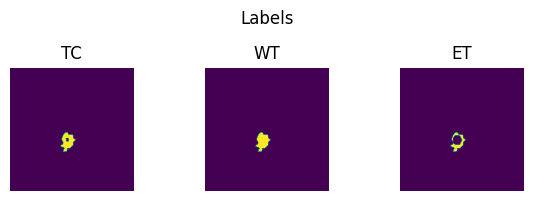

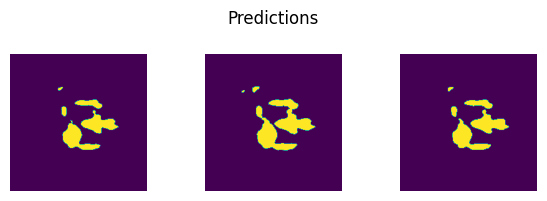

epoch 3
   average train loss: 0.9594
   average validation loss: 0.9796
   saved as best model: False
   current mean dice: 0.1340
   current TC dice: 0.1491
   current WT dice: 0.1303
   current ET dice: 0.1357
Best Mean Metric: 0.1813
time consuming of epoch 3 is: 1661.9667
----------
epoch 4/10
TRAIN
   Batch 1/248, train_loss: 0.8532, step time: 1.4263
   Batch 2/248, train_loss: 0.9998, step time: 1.3430
   Batch 3/248, train_loss: 0.9975, step time: 1.3472
   Batch 4/248, train_loss: 0.9999, step time: 1.3459
   Batch 5/248, train_loss: 0.9867, step time: 1.3722
   Batch 6/248, train_loss: 0.9873, step time: 1.3891
   Batch 7/248, train_loss: 0.8078, step time: 1.3826
   Batch 8/248, train_loss: 0.9650, step time: 1.3652
   Batch 9/248, train_loss: 0.8651, step time: 1.3842
   Batch 10/248, train_loss: 0.9946, step time: 1.3585
   Batch 11/248, train_loss: 0.9890, step time: 1.3747
   Batch 12/248, train_loss: 0.9997, step time: 1.3449
   Batch 13/248, train_loss: 0.9964, step t

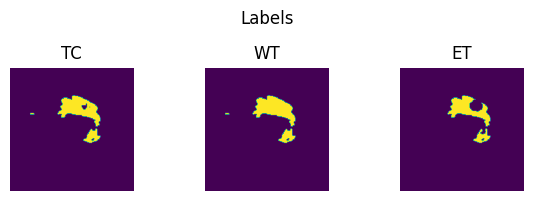

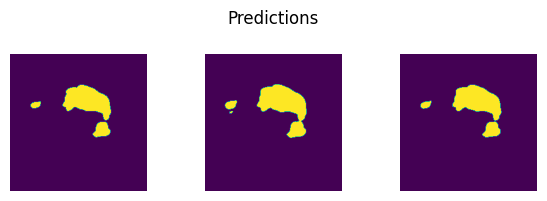

VAL
   Batch 1/31, val_loss: 0.9710
   Batch 2/31, val_loss: 0.9999
   Batch 3/31, val_loss: 0.9996
   Batch 4/31, val_loss: 0.9967
   Batch 5/31, val_loss: 1.0000
   Batch 6/31, val_loss: 0.8584
   Batch 7/31, val_loss: 0.9652
   Batch 8/31, val_loss: 0.9969
   Batch 9/31, val_loss: 0.8778
   Batch 10/31, val_loss: 0.9950
   Batch 11/31, val_loss: 0.9735
   Batch 12/31, val_loss: 0.9983
   Batch 13/31, val_loss: 0.9975
   Batch 14/31, val_loss: 0.9966
   Batch 15/31, val_loss: 0.9999
   Batch 16/31, val_loss: 0.9990
   Batch 17/31, val_loss: 0.9996
   Batch 18/31, val_loss: 0.9970
   Batch 19/31, val_loss: 0.9368
   Batch 20/31, val_loss: 0.9723
   Batch 21/31, val_loss: 0.9870
   Batch 22/31, val_loss: 0.9995
   Batch 23/31, val_loss: 0.9994
   Batch 24/31, val_loss: 0.8423
   Batch 25/31, val_loss: 0.9544
   Batch 26/31, val_loss: 0.9906
   Batch 27/31, val_loss: 0.9998
   Batch 28/31, val_loss: 0.9450
   Batch 29/31, val_loss: 0.9999
   Batch 30/31, val_loss: 0.9992
   Batch 31/31,

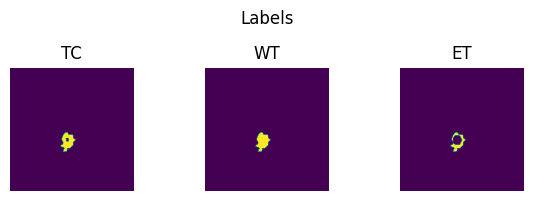

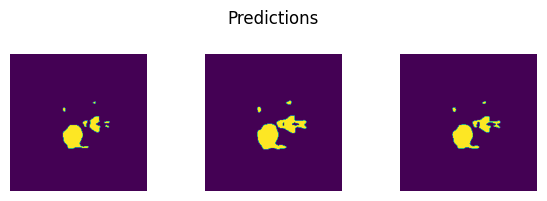

epoch 4
   average train loss: 0.9493
   average validation loss: 0.9757
   saved as best model: False
   current mean dice: 0.1752
   current TC dice: 0.1945
   current WT dice: 0.1731
   current ET dice: 0.1750
Best Mean Metric: 0.1813
time consuming of epoch 4 is: 1689.0250
----------
epoch 5/10
TRAIN
   Batch 1/248, train_loss: 0.8124, step time: 1.4404
   Batch 2/248, train_loss: 0.9998, step time: 1.3766
   Batch 3/248, train_loss: 0.9967, step time: 1.3814
   Batch 4/248, train_loss: 0.9999, step time: 1.3434
   Batch 5/248, train_loss: 0.9822, step time: 1.3725
   Batch 6/248, train_loss: 0.9822, step time: 1.3820
   Batch 7/248, train_loss: 0.7372, step time: 1.3960
   Batch 8/248, train_loss: 0.9560, step time: 1.3837
   Batch 9/248, train_loss: 0.8280, step time: 1.3913
   Batch 10/248, train_loss: 0.9930, step time: 1.3906
   Batch 11/248, train_loss: 0.9842, step time: 1.3690
   Batch 12/248, train_loss: 0.9995, step time: 1.3640
   Batch 13/248, train_loss: 0.9953, step t

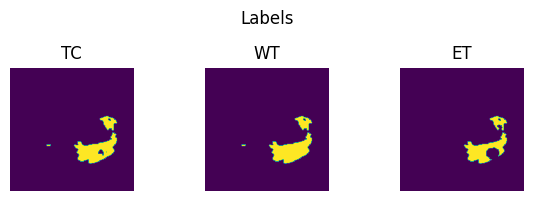

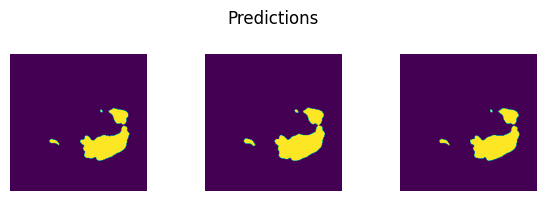

VAL
   Batch 1/31, val_loss: 0.9680
   Batch 2/31, val_loss: 0.9999
   Batch 3/31, val_loss: 0.9996
   Batch 4/31, val_loss: 0.9958
   Batch 5/31, val_loss: 1.0000
   Batch 6/31, val_loss: 0.8393
   Batch 7/31, val_loss: 0.9603
   Batch 8/31, val_loss: 0.9966
   Batch 9/31, val_loss: 0.8595
   Batch 10/31, val_loss: 0.9946
   Batch 11/31, val_loss: 0.9688
   Batch 12/31, val_loss: 0.9982
   Batch 13/31, val_loss: 0.9968
   Batch 14/31, val_loss: 0.9963
   Batch 15/31, val_loss: 0.9999
   Batch 16/31, val_loss: 0.9989
   Batch 17/31, val_loss: 0.9995
   Batch 18/31, val_loss: 0.9972
   Batch 19/31, val_loss: 0.9255
   Batch 20/31, val_loss: 0.9694
   Batch 21/31, val_loss: 0.9864
   Batch 22/31, val_loss: 0.9993
   Batch 23/31, val_loss: 0.9993
   Batch 24/31, val_loss: 0.8260
   Batch 25/31, val_loss: 0.9441
   Batch 26/31, val_loss: 0.9881
   Batch 27/31, val_loss: 0.9998
   Batch 28/31, val_loss: 0.9384
   Batch 29/31, val_loss: 0.9999
   Batch 30/31, val_loss: 0.9991
   Batch 31/31,

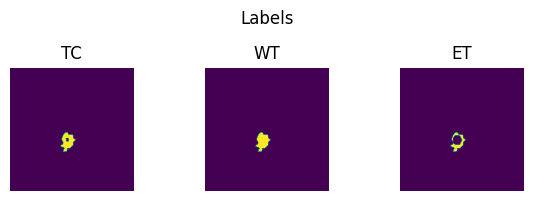

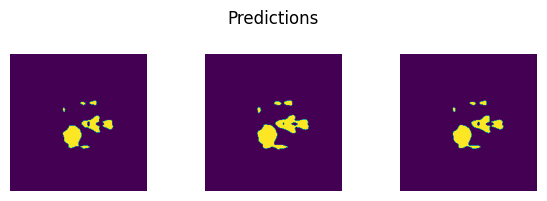

epoch 5
   average train loss: 0.9358
   average validation loss: 0.9724
   saved as best model: False
   current mean dice: 0.1810
   current TC dice: 0.1979
   current WT dice: 0.1801
   current ET dice: 0.1826
Best Mean Metric: 0.1813
time consuming of epoch 5 is: 1660.2474
----------
epoch 6/10
TRAIN
   Batch 1/248, train_loss: 0.7677, step time: 1.3924
   Batch 2/248, train_loss: 0.9997, step time: 1.3294
   Batch 3/248, train_loss: 0.9963, step time: 1.3539
   Batch 4/248, train_loss: 0.9998, step time: 1.3559
   Batch 5/248, train_loss: 0.9799, step time: 1.3457
   Batch 6/248, train_loss: 0.9789, step time: 1.3466
   Batch 7/248, train_loss: 0.6896, step time: 1.3725
   Batch 8/248, train_loss: 0.9452, step time: 1.3562
   Batch 9/248, train_loss: 0.7871, step time: 1.3621
   Batch 10/248, train_loss: 0.9924, step time: 1.3281
   Batch 11/248, train_loss: 0.9843, step time: 1.3707
   Batch 12/248, train_loss: 0.9996, step time: 1.3533
   Batch 13/248, train_loss: 0.9944, step t

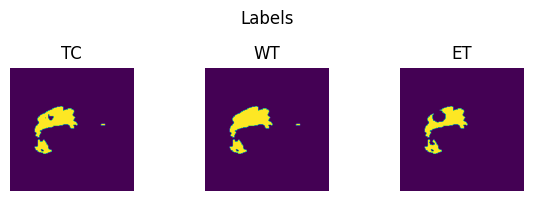

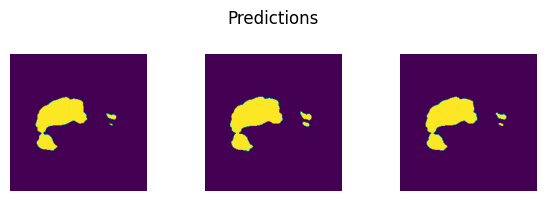

VAL
   Batch 1/31, val_loss: 0.9652
   Batch 2/31, val_loss: 0.9999
   Batch 3/31, val_loss: 0.9996
   Batch 4/31, val_loss: 0.9950
   Batch 5/31, val_loss: 1.0000
   Batch 6/31, val_loss: 0.8298
   Batch 7/31, val_loss: 0.9607
   Batch 8/31, val_loss: 0.9967
   Batch 9/31, val_loss: 0.8580
   Batch 10/31, val_loss: 0.9952
   Batch 11/31, val_loss: 0.9700
   Batch 12/31, val_loss: 0.9982
   Batch 13/31, val_loss: 0.9965
   Batch 14/31, val_loss: 0.9962
   Batch 15/31, val_loss: 0.9999
   Batch 16/31, val_loss: 0.9991
   Batch 17/31, val_loss: 0.9995
   Batch 18/31, val_loss: 0.9974
   Batch 19/31, val_loss: 0.9234
   Batch 20/31, val_loss: 0.9677
   Batch 21/31, val_loss: 0.9874
   Batch 22/31, val_loss: 0.9992
   Batch 23/31, val_loss: 0.9993
   Batch 24/31, val_loss: 0.8208
   Batch 25/31, val_loss: 0.9422
   Batch 26/31, val_loss: 0.9881
   Batch 27/31, val_loss: 0.9998
   Batch 28/31, val_loss: 0.9413
   Batch 29/31, val_loss: 0.9999
   Batch 30/31, val_loss: 0.9992
   Batch 31/31,

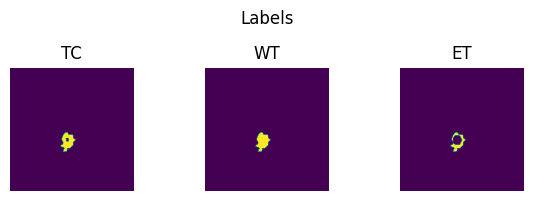

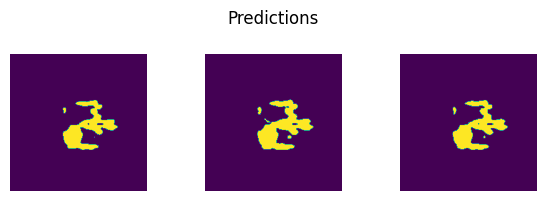

epoch 6
   average train loss: 0.9228
   average validation loss: 0.9717
   saved as best model: False
   current mean dice: 0.1422
   current TC dice: 0.1555
   current WT dice: 0.1417
   current ET dice: 0.1432
Best Mean Metric: 0.1813
time consuming of epoch 6 is: 1692.0349
----------
epoch 7/10
TRAIN
   Batch 1/248, train_loss: 0.7440, step time: 1.4437
   Batch 2/248, train_loss: 0.9997, step time: 1.3783
   Batch 3/248, train_loss: 0.9958, step time: 1.3583
   Batch 4/248, train_loss: 0.9998, step time: 1.3209
   Batch 5/248, train_loss: 0.9771, step time: 1.3379
   Batch 6/248, train_loss: 0.9748, step time: 1.3415
   Batch 7/248, train_loss: 0.6419, step time: 1.3473
   Batch 8/248, train_loss: 0.9412, step time: 1.3865
   Batch 9/248, train_loss: 0.7523, step time: 1.3855
   Batch 10/248, train_loss: 0.9905, step time: 1.3826
   Batch 11/248, train_loss: 0.9818, step time: 1.3605
   Batch 12/248, train_loss: 0.9995, step time: 1.3577
   Batch 13/248, train_loss: 0.9930, step t

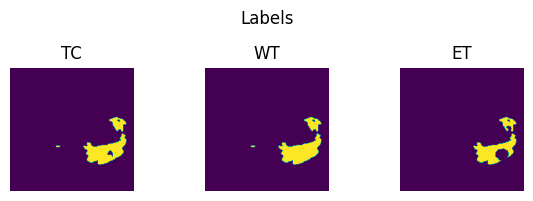

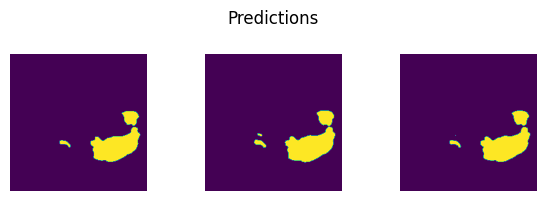

VAL
   Batch 1/31, val_loss: 0.9544
   Batch 2/31, val_loss: 0.9999
   Batch 3/31, val_loss: 0.9990
   Batch 4/31, val_loss: 0.9944
   Batch 5/31, val_loss: 1.0000
   Batch 6/31, val_loss: 0.8170
   Batch 7/31, val_loss: 0.9532
   Batch 8/31, val_loss: 0.9956
   Batch 9/31, val_loss: 0.8414
   Batch 10/31, val_loss: 0.9920
   Batch 11/31, val_loss: 0.9591
   Batch 12/31, val_loss: 0.9964
   Batch 13/31, val_loss: 0.9956
   Batch 14/31, val_loss: 0.9942
   Batch 15/31, val_loss: 0.9999
   Batch 16/31, val_loss: 0.9985
   Batch 17/31, val_loss: 0.9989
   Batch 18/31, val_loss: 0.9946
   Batch 19/31, val_loss: 0.9106
   Batch 20/31, val_loss: 0.9600
   Batch 21/31, val_loss: 0.9783
   Batch 22/31, val_loss: 0.9993
   Batch 23/31, val_loss: 0.9991
   Batch 24/31, val_loss: 0.8140
   Batch 25/31, val_loss: 0.9325
   Batch 26/31, val_loss: 0.9839
   Batch 27/31, val_loss: 0.9997
   Batch 28/31, val_loss: 0.9152
   Batch 29/31, val_loss: 0.9998
   Batch 30/31, val_loss: 0.9991
   Batch 31/31,

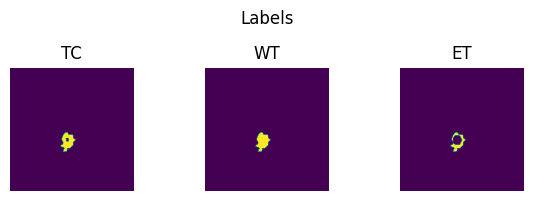

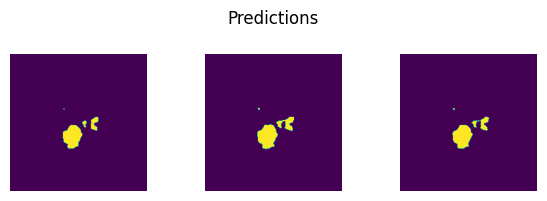

epoch 7
   average train loss: 0.9109
   average validation loss: 0.9669
   saved as best model: True
   current mean dice: 0.2027
   current TC dice: 0.2211
   current WT dice: 0.2064
   current ET dice: 0.2000
Best Mean Metric: 0.2027
time consuming of epoch 7 is: 1679.6714
----------
epoch 8/10
TRAIN
   Batch 1/248, train_loss: 0.7059, step time: 1.4568
   Batch 2/248, train_loss: 0.9997, step time: 1.3793
   Batch 3/248, train_loss: 0.9948, step time: 1.3937
   Batch 4/248, train_loss: 0.9998, step time: 1.3504
   Batch 5/248, train_loss: 0.9704, step time: 1.4022
   Batch 6/248, train_loss: 0.9699, step time: 1.3708
   Batch 7/248, train_loss: 0.6004, step time: 1.3794
   Batch 8/248, train_loss: 0.9296, step time: 1.3758
   Batch 9/248, train_loss: 0.7204, step time: 1.4005
   Batch 10/248, train_loss: 0.9886, step time: 1.3840
   Batch 11/248, train_loss: 0.9750, step time: 1.3755
   Batch 12/248, train_loss: 0.9991, step time: 1.3906
   Batch 13/248, train_loss: 0.9919, step ti

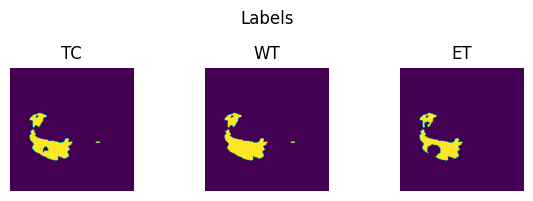

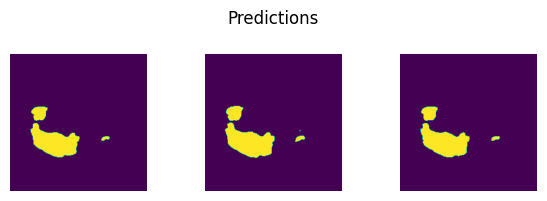

VAL
   Batch 1/31, val_loss: 0.9507
   Batch 2/31, val_loss: 0.9999
   Batch 3/31, val_loss: 0.9989
   Batch 4/31, val_loss: 0.9940
   Batch 5/31, val_loss: 1.0000
   Batch 6/31, val_loss: 0.8111
   Batch 7/31, val_loss: 0.9506
   Batch 8/31, val_loss: 0.9946
   Batch 9/31, val_loss: 0.8356
   Batch 10/31, val_loss: 0.9906
   Batch 11/31, val_loss: 0.9558
   Batch 12/31, val_loss: 0.9960
   Batch 13/31, val_loss: 0.9952
   Batch 14/31, val_loss: 0.9933
   Batch 15/31, val_loss: 0.9999
   Batch 16/31, val_loss: 0.9983
   Batch 17/31, val_loss: 0.9990
   Batch 18/31, val_loss: 0.9933
   Batch 19/31, val_loss: 0.9069
   Batch 20/31, val_loss: 0.9580
   Batch 21/31, val_loss: 0.9734
   Batch 22/31, val_loss: 0.9993
   Batch 23/31, val_loss: 0.9992
   Batch 24/31, val_loss: 0.8100
   Batch 25/31, val_loss: 0.9290
   Batch 26/31, val_loss: 0.9828
   Batch 27/31, val_loss: 0.9997
   Batch 28/31, val_loss: 0.9080
   Batch 29/31, val_loss: 0.9998
   Batch 30/31, val_loss: 0.9990
   Batch 31/31,

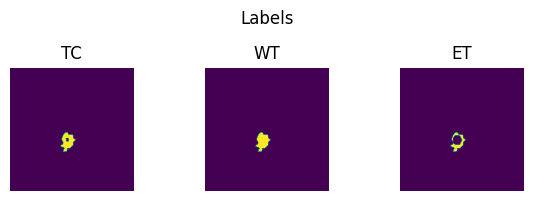

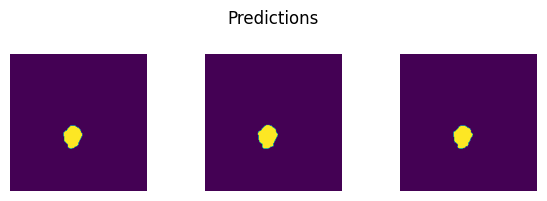

epoch 8
   average train loss: 0.9016
   average validation loss: 0.9652
   saved as best model: True
   current mean dice: 0.2208
   current TC dice: 0.2398
   current WT dice: 0.2263
   current ET dice: 0.2173
Best Mean Metric: 0.2208
time consuming of epoch 8 is: 1678.1710
----------
epoch 9/10
TRAIN
   Batch 1/248, train_loss: 0.6846, step time: 1.4340
   Batch 2/248, train_loss: 0.9996, step time: 1.3581
   Batch 3/248, train_loss: 0.9936, step time: 1.3723
   Batch 4/248, train_loss: 0.9998, step time: 1.3262
   Batch 5/248, train_loss: 0.9659, step time: 1.3403
   Batch 6/248, train_loss: 0.9649, step time: 1.3602
   Batch 7/248, train_loss: 0.5817, step time: 1.3643
   Batch 8/248, train_loss: 0.9230, step time: 1.3422
   Batch 9/248, train_loss: 0.7025, step time: 1.3471
   Batch 10/248, train_loss: 0.9878, step time: 1.3146
   Batch 11/248, train_loss: 0.9732, step time: 1.3566
   Batch 12/248, train_loss: 0.9989, step time: 1.3293
   Batch 13/248, train_loss: 0.9916, step ti

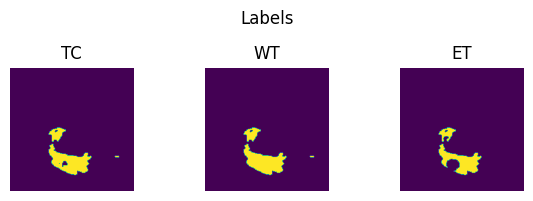

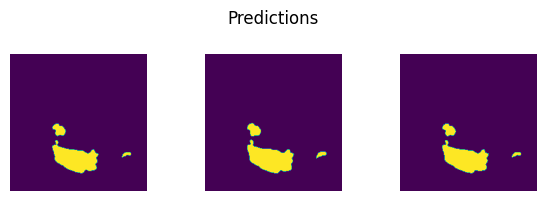

VAL
   Batch 1/31, val_loss: 0.9482
   Batch 2/31, val_loss: 0.9999
   Batch 3/31, val_loss: 0.9978
   Batch 4/31, val_loss: 0.9938
   Batch 5/31, val_loss: 0.9999
   Batch 6/31, val_loss: 0.8071
   Batch 7/31, val_loss: 0.9427
   Batch 8/31, val_loss: 0.9939
   Batch 9/31, val_loss: 0.8291
   Batch 10/31, val_loss: 0.9868
   Batch 11/31, val_loss: 0.9524
   Batch 12/31, val_loss: 0.9961
   Batch 13/31, val_loss: 0.9952
   Batch 14/31, val_loss: 0.9931
   Batch 15/31, val_loss: 0.9998
   Batch 16/31, val_loss: 0.9980
   Batch 17/31, val_loss: 0.9989
   Batch 18/31, val_loss: 0.9922
   Batch 19/31, val_loss: 0.9041
   Batch 20/31, val_loss: 0.9525
   Batch 21/31, val_loss: 0.9693
   Batch 22/31, val_loss: 0.9994
   Batch 23/31, val_loss: 0.9993
   Batch 24/31, val_loss: 0.8055
   Batch 25/31, val_loss: 0.9255
   Batch 26/31, val_loss: 0.9818
   Batch 27/31, val_loss: 0.9992
   Batch 28/31, val_loss: 0.9018
   Batch 29/31, val_loss: 0.9998
   Batch 30/31, val_loss: 0.9985
   Batch 31/31,

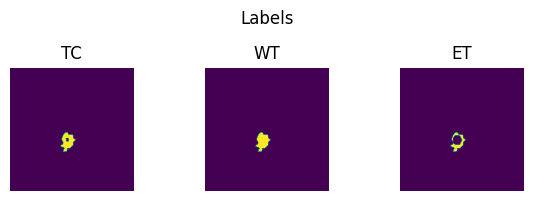

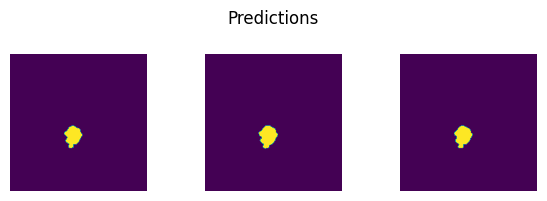

epoch 9
   average train loss: 0.8964
   average validation loss: 0.9632
   saved as best model: True
   current mean dice: 0.2703
   current TC dice: 0.2973
   current WT dice: 0.2748
   current ET dice: 0.2643
Best Mean Metric: 0.2703
time consuming of epoch 9 is: 1667.2914
----------
epoch 10/10
TRAIN
   Batch 1/248, train_loss: 0.6704, step time: 1.4397
   Batch 2/248, train_loss: 0.9997, step time: 1.4008
   Batch 3/248, train_loss: 0.9915, step time: 1.3791
   Batch 4/248, train_loss: 0.9998, step time: 1.3604
   Batch 5/248, train_loss: 0.9619, step time: 1.4018
   Batch 6/248, train_loss: 0.9606, step time: 1.3680
   Batch 7/248, train_loss: 0.5753, step time: 1.3793
   Batch 8/248, train_loss: 0.9227, step time: 1.3916
   Batch 9/248, train_loss: 0.6935, step time: 1.4074
   Batch 10/248, train_loss: 0.9830, step time: 1.3964
   Batch 11/248, train_loss: 0.9624, step time: 1.4171
   Batch 12/248, train_loss: 0.9985, step time: 1.3882
   Batch 13/248, train_loss: 0.9917, step t

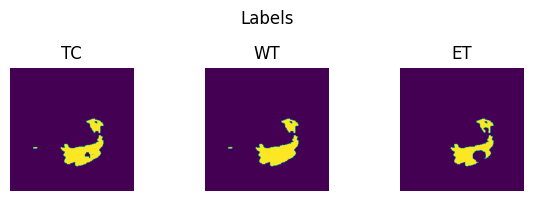

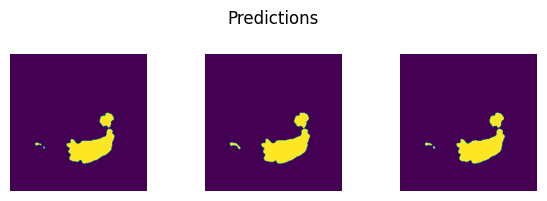

VAL
   Batch 1/31, val_loss: 0.9482
   Batch 2/31, val_loss: 0.9999
   Batch 3/31, val_loss: 0.9977
   Batch 4/31, val_loss: 0.9936
   Batch 5/31, val_loss: 0.9999
   Batch 6/31, val_loss: 0.8053
   Batch 7/31, val_loss: 0.9418
   Batch 8/31, val_loss: 0.9938
   Batch 9/31, val_loss: 0.8267
   Batch 10/31, val_loss: 0.9865
   Batch 11/31, val_loss: 0.9514
   Batch 12/31, val_loss: 0.9959
   Batch 13/31, val_loss: 0.9951
   Batch 14/31, val_loss: 0.9926
   Batch 15/31, val_loss: 0.9997
   Batch 16/31, val_loss: 0.9979
   Batch 17/31, val_loss: 0.9988
   Batch 18/31, val_loss: 0.9922
   Batch 19/31, val_loss: 0.9023
   Batch 20/31, val_loss: 0.9514
   Batch 21/31, val_loss: 0.9685
   Batch 22/31, val_loss: 0.9993
   Batch 23/31, val_loss: 0.9992
   Batch 24/31, val_loss: 0.8035
   Batch 25/31, val_loss: 0.9240
   Batch 26/31, val_loss: 0.9817
   Batch 27/31, val_loss: 0.9992
   Batch 28/31, val_loss: 0.8995
   Batch 29/31, val_loss: 0.9997
   Batch 30/31, val_loss: 0.9984
   Batch 31/31,

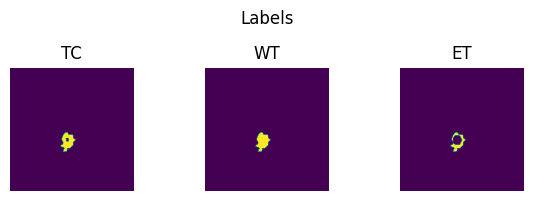

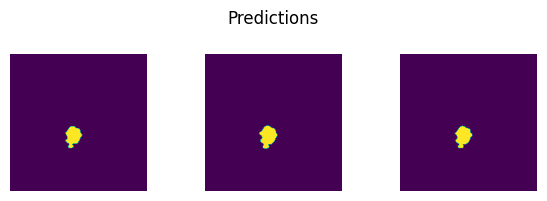

epoch 10
   average train loss: 0.8937
   average validation loss: 0.9626
   saved as best model: True
   current mean dice: 0.2777
   current TC dice: 0.3056
   current WT dice: 0.2822
   current ET dice: 0.2715
Best Mean Metric: 0.2777
time consuming of epoch 10 is: 1661.1676


In [11]:
total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")

    # TRAINING
    model.train()
    epoch_loss = 0
    step = 0
    print('TRAIN')
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()

        print(f"   Batch {step}/{len(train_dataset) // train_loader.batch_size}"
              f", train_loss: {loss.item():.4f}"
              f", step time: {(time.time() - step_start):.4f}")

        # Store the image to plot
        if step == max_step:
          plt_imgs = [labels[0], transforms.post()(outputs[0])]

    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)

    # Plot the Img
    if (epoch + 1) % plot_interval == 0:
      plot_gt_vs_pred(plt_imgs[0], plt_imgs[1], True)

    # VALIDATION
    print('VAL')
    val_loss = 0
    val_step = 0
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            best_val_dice = -1
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_step += 1
                val_outputs = inference(val_inputs)
                loss_value = loss_function(val_outputs[0], val_labels[0])
                val_loss += loss_value.item()

                val_outputs = [transforms.post()(x) for x in val_outputs]

                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

                print(f"   Batch {val_step}/{len(val_dataset) // val_loader.batch_size}"
                      f", val_loss: {loss_value.item():.4f}")

                # Store plot image
                if val_step == max_val_step:
                  plt_imgs = [val_labels[0], val_outputs[0]]

            val_loss /= val_step
            val_loss_values.append(val_loss)

            # Plot the img
            if (epoch + 1) % plot_interval == 0:
              plot_gt_vs_pred(plt_imgs[0], plt_imgs[1], False)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(f"outputs/{model_name}/{model_name}_{epoch+1}.pth"),
                )
                best_metric_update = True

            # Save all metrics in csv
            with open(f"outputs/{model_name}/{model_name}_metrics.csv", "a") as f:
                f.write(f"{epoch + 1},{metric},{metric_tc},{metric_wt},{metric_et},{epoch_loss},{val_loss}\n")

    # REPORT
    print(f"epoch {epoch + 1}\n"
          f"   average train loss: {epoch_loss:.4f}\n"
          f"   average validation loss: {val_loss:.4f}\n"
          f"   saved as best model: {best_metric_update}\n"
          f"   current mean dice: {metric_values[-1]:.4f}\n"
          f"   current TC dice: {metric_values_tc[-1]:.4f}\n"
          f"   current WT dice: {metric_values_wt[-1]:.4f}\n"
          f"   current ET dice: {metric_values_et[-1]:.4f}")
    print(f"Best Mean Metric: {best_metric:.4f}")
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
    best_metric_update = False

    # When epoch ends, clean GPU memory
    torch.cuda.empty_cache()

total_time = time.time() - total_start

In [12]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

train completed, best_metric: 0.2777 at epoch: 10, total time: 20023.27721643448.


### Plot the loss and metric

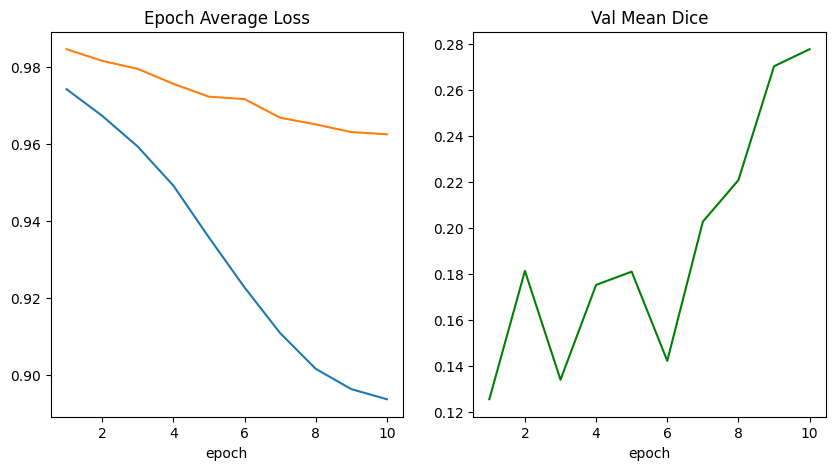

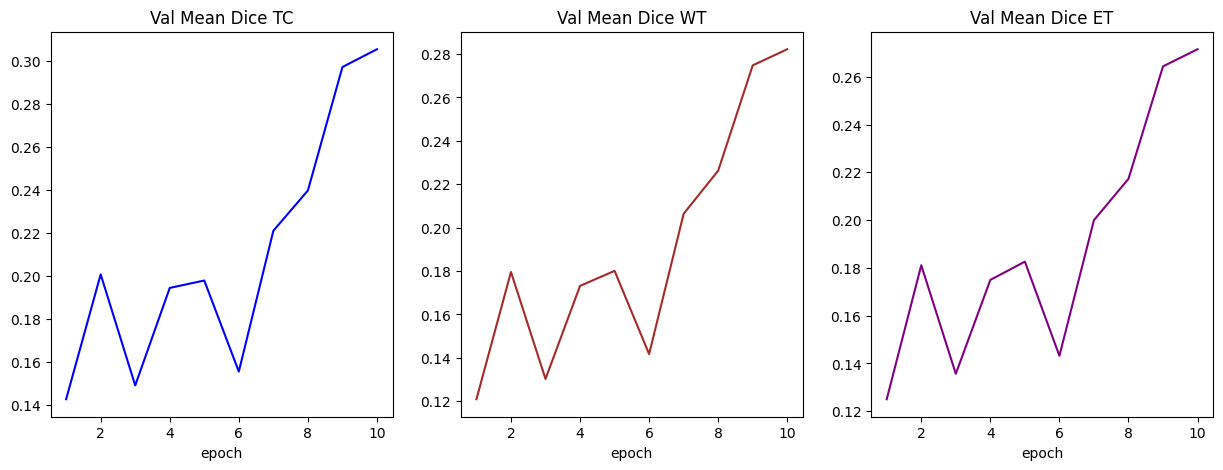

In [13]:
plt.figure("train", (10, 5))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
plt.xlabel("epoch")
plt.plot(x, epoch_loss_values)
plt.plot(x, val_loss_values)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (15, 5))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()